<a href="https://colab.research.google.com/github/bartianbosch/Melk/blob/Oscar/Big_Data_Milk_Oscar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Big Data Groupwork Milk


In [ ]:
# To download and update the necessary requirements initialize Apache Spark, run this cell
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
sp = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# Added imports
import seaborn as sns

from pyspark import SparkFiles

import pandas as pd
import matplotlib.pyplot as plt
plt.close('all')
plt.rcParams['figure.figsize'] = [30, 20]

from pyspark.sql import types
from pyspark.sql import functions as F

# Mounting drive
from google.colab import drive
drive.mount('/content/gdrive/')

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downl

Loading the data into a DF


In [ ]:
# Work from dataframes is sufficient
url = 'https://raw.githubusercontent.com/bartianbosch/Melk/main/ff_dairy_v1_preprocessed.csv'
fileName = url.split('/')[-1]

spark.sparkContext.addFile(url)

milk_rdd = spark.read.csv(SparkFiles.get(fileName), header=True)


# Also loading to pandas table just in case we need it for testing
milk_pd=pd.read_csv(url, encoding='latin1')


In [ ]:
# To check pandas dataframe, run this cell

#milk_pd

In [ ]:
milk_rdd.show(5)

+----------+-------+----+---------+---------+----------------+------------+----------+----+------------------------------------------+-----------------------------------------------+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+-----------------+---------------+----+--------+------------+--------------+--------+----------------------+---------+----------------------+-------------------------+------+----------------------+---------------+-------------------------------------+--------------------------------------+-----------------+-------------------------+-------------------+-----------------------+-------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+-------



---


## Creating a Machine Learning Model

### Data Preparation

In [213]:
from pyspark.sql import functions as F
def fixType(datasetName, colName, dataType):
  """Takes a dataset and returns the dataset with the given column set to the given dataype"""
  return datasetName.withColumn(colName, F.col(colName).cast(dataType))

# Preparing Lists with the colum names and which type they need to be
allColumns = ['Cow number', 'Date', 'Barn', 'Barn part', 'Treatment', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)', 'Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Backfat Thickness', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Rumination time (min/day)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure dm (g/kg OM)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
doubleColumns = ['Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)']
intColumns = ['Cow number', 'Barn', 'Barn part', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Backfat Thickness', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Rumination time (min/day)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Manure dm (g/kg OM)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
stringColumn = ['Treatment', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)']
milk_rdd2 = milk_rdd

# Setting the columns to the correct type
for colName in doubleColumns:
  milk_rdd2 = fixType(milk_rdd2, colName, "double")
for colName in intColumns:
  milk_rdd2 = fixType(milk_rdd2, colName, "int")
milk_rdd2 = milk_rdd2.withColumn("Date", F.col("Date").cast("date"))

#milk_rdd2.printSchema()


28


ValueError: ignored

<Figure size 720x720 with 0 Axes>

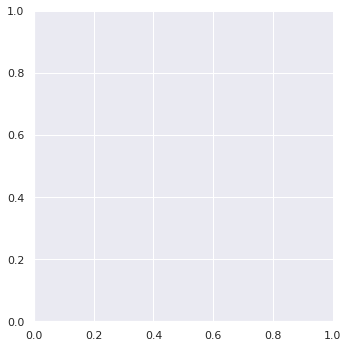

In [234]:
# Create the vectorizer that adds the features column needed to run a machine learning pipeline
### To change on which columns the LR model is build you only need to change the following 2 variables ###
#inputColNames = ['Water intake (kg)','Fat%', 'Protein%', 'Lactose%','Urea (mg/kg)', 'SCC (*1000/ml)']
print(len(doubleColumns))
inputColNames = doubleColumns[0:10]
labelColName = "Milk yield (kg)"
predictionColName = "Predicted " + labelColName

from pyspark.ml.feature import VectorAssembler
vectorizer = VectorAssembler(
    inputCols=inputColNames, #add columns you want to check out here
    outputCol="features")

# Drop empty values (otherwise it we can't work with the data)
milk_rdd3 = milk_rdd2.dropna(how='any', subset=inputColNames+[labelColName])

# Plotting the columns versus the labelcolumn to get inital idea of linear regression
milk_rdd3_sample = milk_rdd3.select(inputColNames+[labelColName]).sample(False,0.5)
#print(milk_rdd3_sample)
sns.set(rc={'figure.figsize':(10,10)})

for column in inputColNames:
  plt.figure()
  sns.lmplot(x=column, y=labelColName,data=milk_rdd3_sample.toPandas())
  plt.title(labelColName+" vs "+column)
  plt.xlabel(column)
  plt.ylabel(labelColName)

In [169]:
# Splitting the dataset into a training and testing portion.
#Setting a seed for reproducible results.
ourSeed = 1234  # default = 1234
(testSetDF, trainingSetDF) = milk_rdd3.randomSplit([2.0,8.0],seed=ourSeed)

# Uncomment to cache these datasets for performance
testSetDF.cache()
trainingSetDF.cache()

DataFrame[Cow number: int, Date: date, Barn: int, Barn part: int, Treatment: string, Lactation number: int, Days in milk: int, Day number: int, Week: int, Period (VP = preperiod, HP = trial period): string, Period part (VP = preperiod, HP = trial period): string, Intake basal ration (kg dm): double, Intake total ration (kg dm): double, Water intake (kg): double, Concentrate intake (kg): double, Weight (kg): double, BCS: double, Backfat Thickness: int, Milk yield (kg): double, Fat%: double, Protein%: double, Urea (mg/kg): int, SCC (*1000/ml): int, Lactose%: double, Avg Temperature (degC): double, Air speed: double, Max temperature (degC): double, Rumination time (min/day): int, Avg pH: double, Avg Rumen Temperature : double, Time pH<5,8 (h): double, Manure consistency (1=fluid, 5= hard): int, Manure fibre score (1=short, 5 = long): int, Number of kernels: double, Manure sieving residu (%): double, Manure dm (g/kg OM): int, Manure starch (g/kg dm): double, Urin-pH: double, Intake pre-per

### Linear Regression Machine Learning Model

In [170]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml import Pipeline

# Initialize the linear regression learner with default values for the parameters
lr = LinearRegression()

# Give the name of the column with the values that need to be learned
# and set the name of the collumn where the predicted results will be saved.
lr.setLabelCol(labelColName)\
  .setPredictionCol(predictionColName)

# Create a pipeline that performs the vectorizer and the Linear Regression
# learning model.
lrPipeline = Pipeline()
lrPipeline.setStages([vectorizer, lr])

trainingSetDF.show(5)

# Train the model on the training set with the default settings.
lrModel = lrPipeline.fit(trainingSetDF)


+----------+----+----+---------+---------+----------------+------------+----------+----+------------------------------------------+-----------------------------------------------+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+-----------------+---------------+----+--------+------------+--------------+--------+----------------------+---------+----------------------+-------------------------+------+----------------------+---------------+-------------------------------------+--------------------------------------+-----------------+-------------------------+-------------------+-----------------------+-------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+----------

In [171]:
# Inspecting the results of the previous model

# The coefficients (i.e., weights) are as follows:
weights = lrModel.stages[1].coefficients

# The corresponding features for these weights are:
featuresNoLabel = vectorizer.getInputCols()

# Print coefficients 
list(zip(featuresNoLabel, weights))
print(list(zip(featuresNoLabel, weights)))
 
 # Print the intercept
print("Intercept: ",lrModel.stages[1].intercept)

[('Water intake (kg)', 0.15317343230146355), ('Fat%', -2.5937739700794804), ('Protein%', -6.158627012371102), ('Lactose%', 3.187719969647885), ('Urea (mg/kg)', 0.01032209932226573), ('SCC (*1000/ml)', 0.002533549438708253)]
Intercept:  31.291278134164624


+-----------------+----+--------+--------+------------+--------------+---------------+-------------------------+
|Water intake (kg)|Fat%|Protein%|Lactose%|Urea (mg/kg)|SCC (*1000/ml)|Milk yield (kg)|Predicted Milk yield (kg)|
+-----------------+----+--------+--------+------------+--------------+---------------+-------------------------+
|             49.7|3.78|    2.72|    4.44|         254|            72|           27.2|       29.305772091676626|
|            107.9|3.87|    3.14|    4.63|         206|            84|          44.01|       35.541011469147634|
|             97.3|4.04|    3.01|    4.49|         175|            69|           35.0|        33.47278390712529|
|             89.8|4.04|     3.1|    4.48|         224|            91|          39.92|        32.29935048849703|
|             97.9|4.16|    3.36|    4.62|         230|            60|          38.96|       32.057232749597205|
|             88.0|3.82|    3.39|    4.63|         290|            95|           31.7|       31.

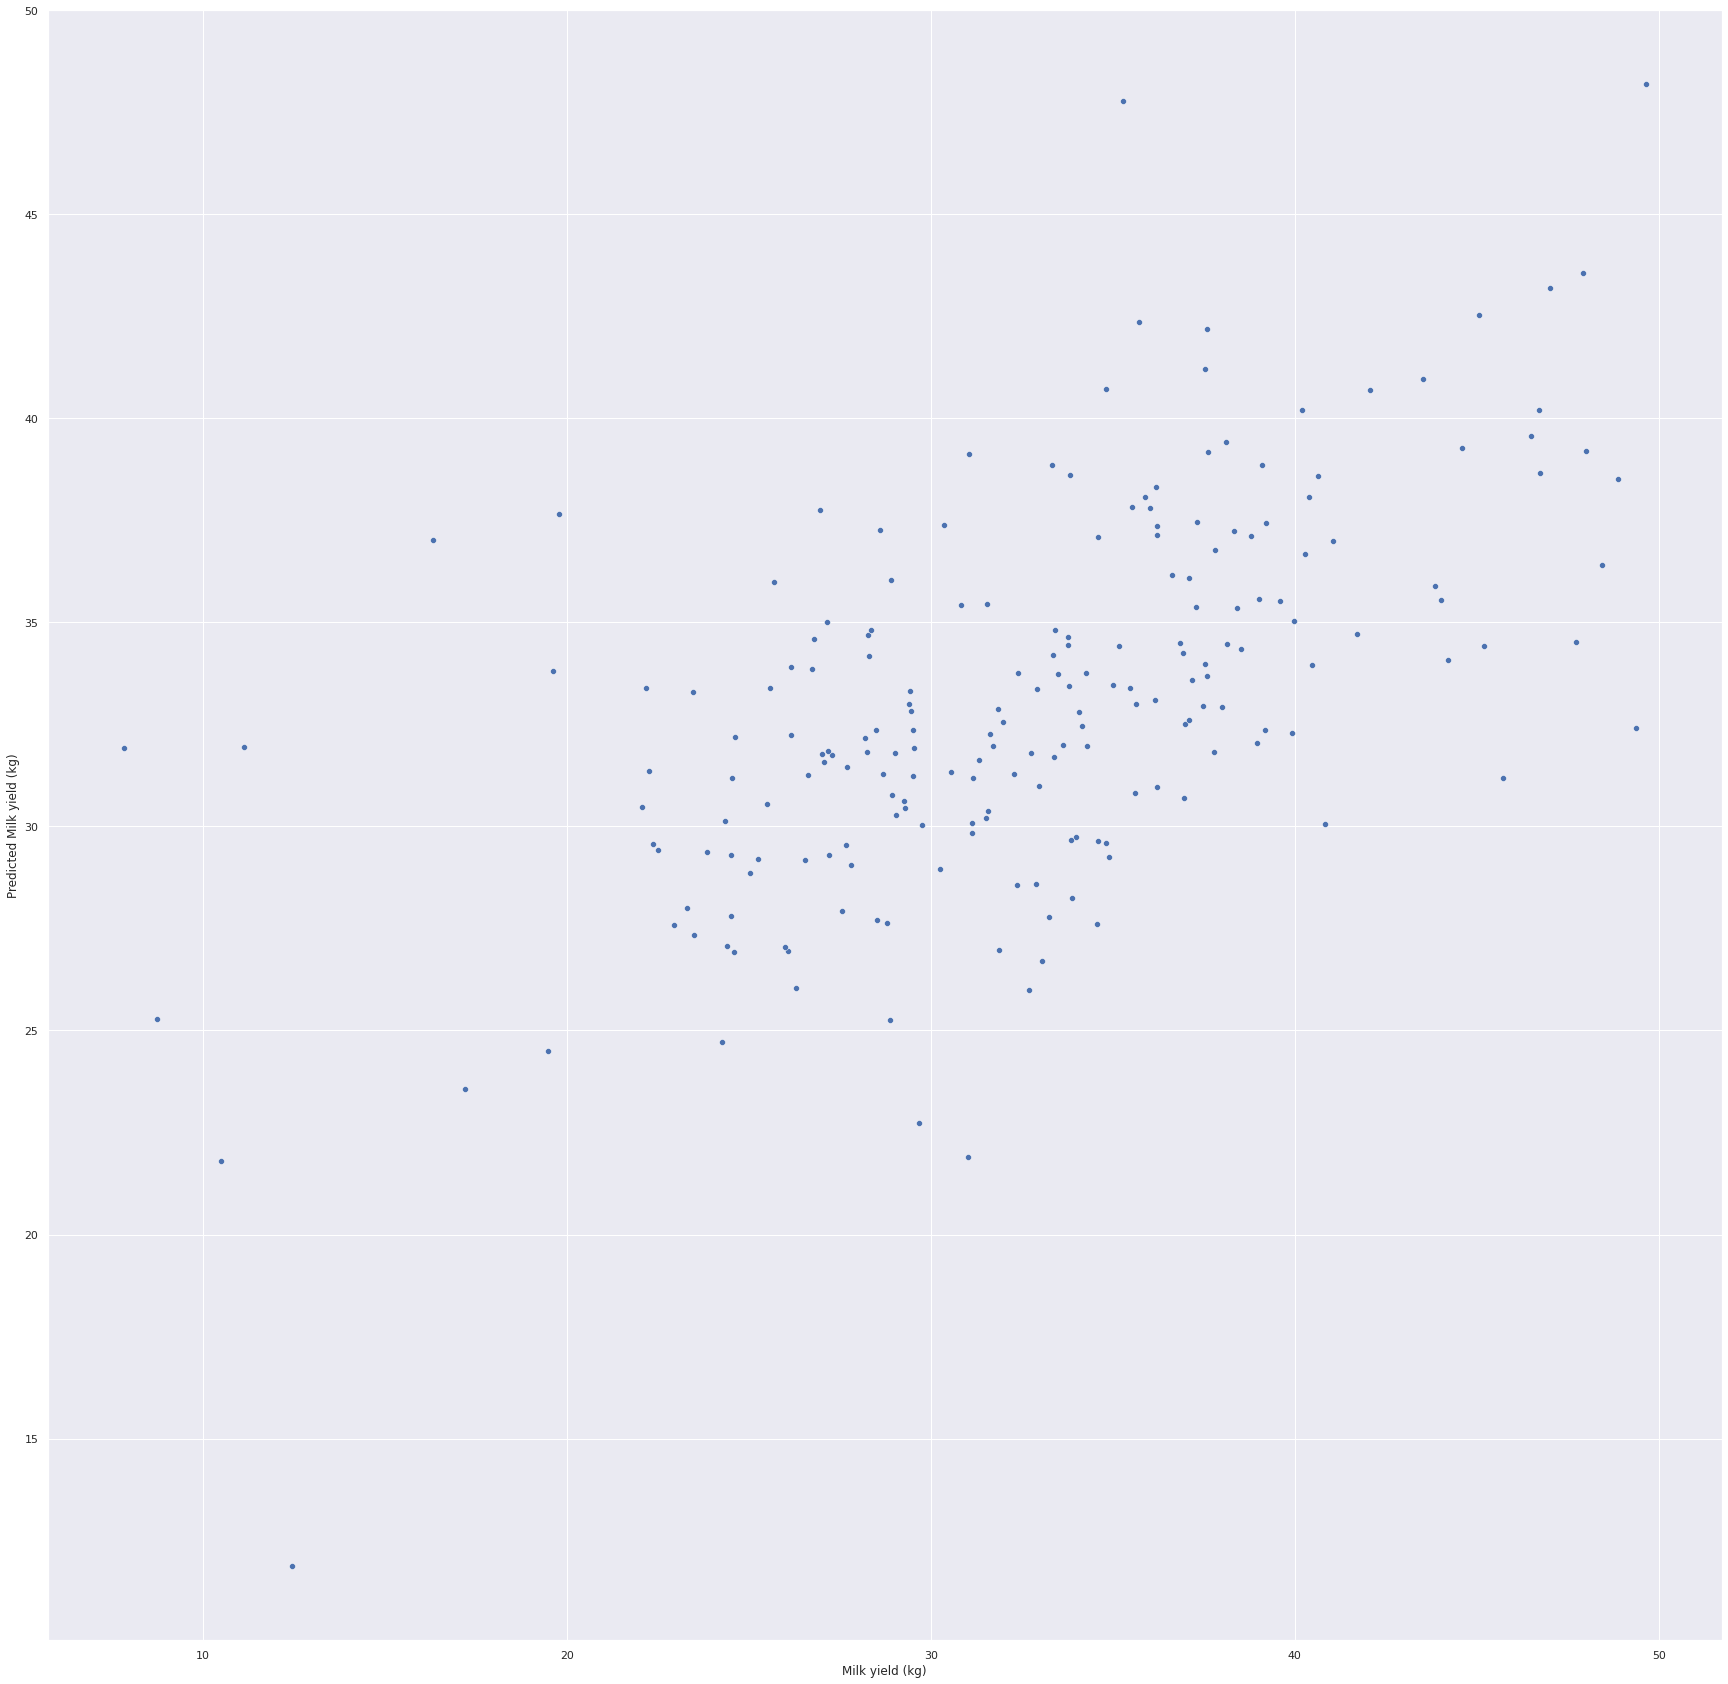

In [172]:
# Model Predictions:

 # Apply our LR model to the test data and predict power output
predictionsLR = lrModel.transform(testSetDF).select(inputColNames+[labelColName]+[predictionColName])

 # Print the first 15 rows of your predictions
predictionsLR.show(15)

#Plotting predicted against actual values to show linearity
sns.scatterplot(x=labelColName, y=predictionColName, data=predictionsLR.toPandas())

In [173]:
 # Now let's compute an evaluation metric for our test dataset
from pyspark.ml.evaluation import RegressionEvaluator

 # Create an RMSE evaluator using the label and predicted columns
regEval = RegressionEvaluator(predictionCol=predictionColName, labelCol=labelColName, metricName="rmse")

 # Run the evaluator on the DataFrame
rmse = regEval.evaluate(predictionsLR)

print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 6.14


In [174]:
 # Now let's compute another evaluation metric for our test dataset
r2 = regEval.evaluate(predictionsLR, {regEval.metricName: "r2"})

print("r2: {0:.2f}".format(r2))

r2: 0.35


### Parameter Tuning and Evaluation

In [175]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

 # We can reuse the RegressionEvaluator, regEval, to judge the model based on the best Root Mean Squared Error
 # Let's create our CrossValidator with 3 fold cross validation
crossval = CrossValidator(estimator=lrPipeline, evaluator=regEval, numFolds=3)

 # Let's tune over our regularization parameter from 0.01 to 0.10
regParam = [x / 100.0 for x in range(1, 11)]

 # We'll create a paramter grid using the ParamGridBuilder, and add the grid to the CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, regParam)
             .build())
crossval.setEstimatorParamMaps(paramGrid)

 # Now let's find and return the best model
cvModel = crossval.fit(trainingSetDF).bestModel

In [176]:
# Now let's use cvModel to compute an evaluation metric for our test dataset: testSetDF
predictionsRL = cvModel.transform(testSetDF).select(inputColNames+[labelColName]+[predictionColName])

# Run the previously created RMSE evaluator, regEval, on the predictionsAndLabelsDF DataFrame
rmseLR = regEval.evaluate(predictionsRL)

# Now let's compute the r2 evaluation metric for our test dataset
r2LR = regEval.evaluate(predictionsRL, {regEval.metricName: "r2"})

print(rmse,rmseLR,r2,r2LR)



print("Original Root Mean Squared Error: {0:2.2f}".format(rmse))
print("New Root Mean Squared Error: {0:2.2f}".format(rmseLR))
print("Old r2: {0:2.2f}".format(r2))
print("New r2: {0:2.2f}".format(r2LR))

6.14472451564034 6.1437337793296285 0.34770770245629223 0.3479180284242459
Original Root Mean Squared Error: 6.14
New Root Mean Squared Error: 6.14
Old r2: 0.35
New r2: 0.35




---


## Oscars Playground


### Random commands for the fun of it

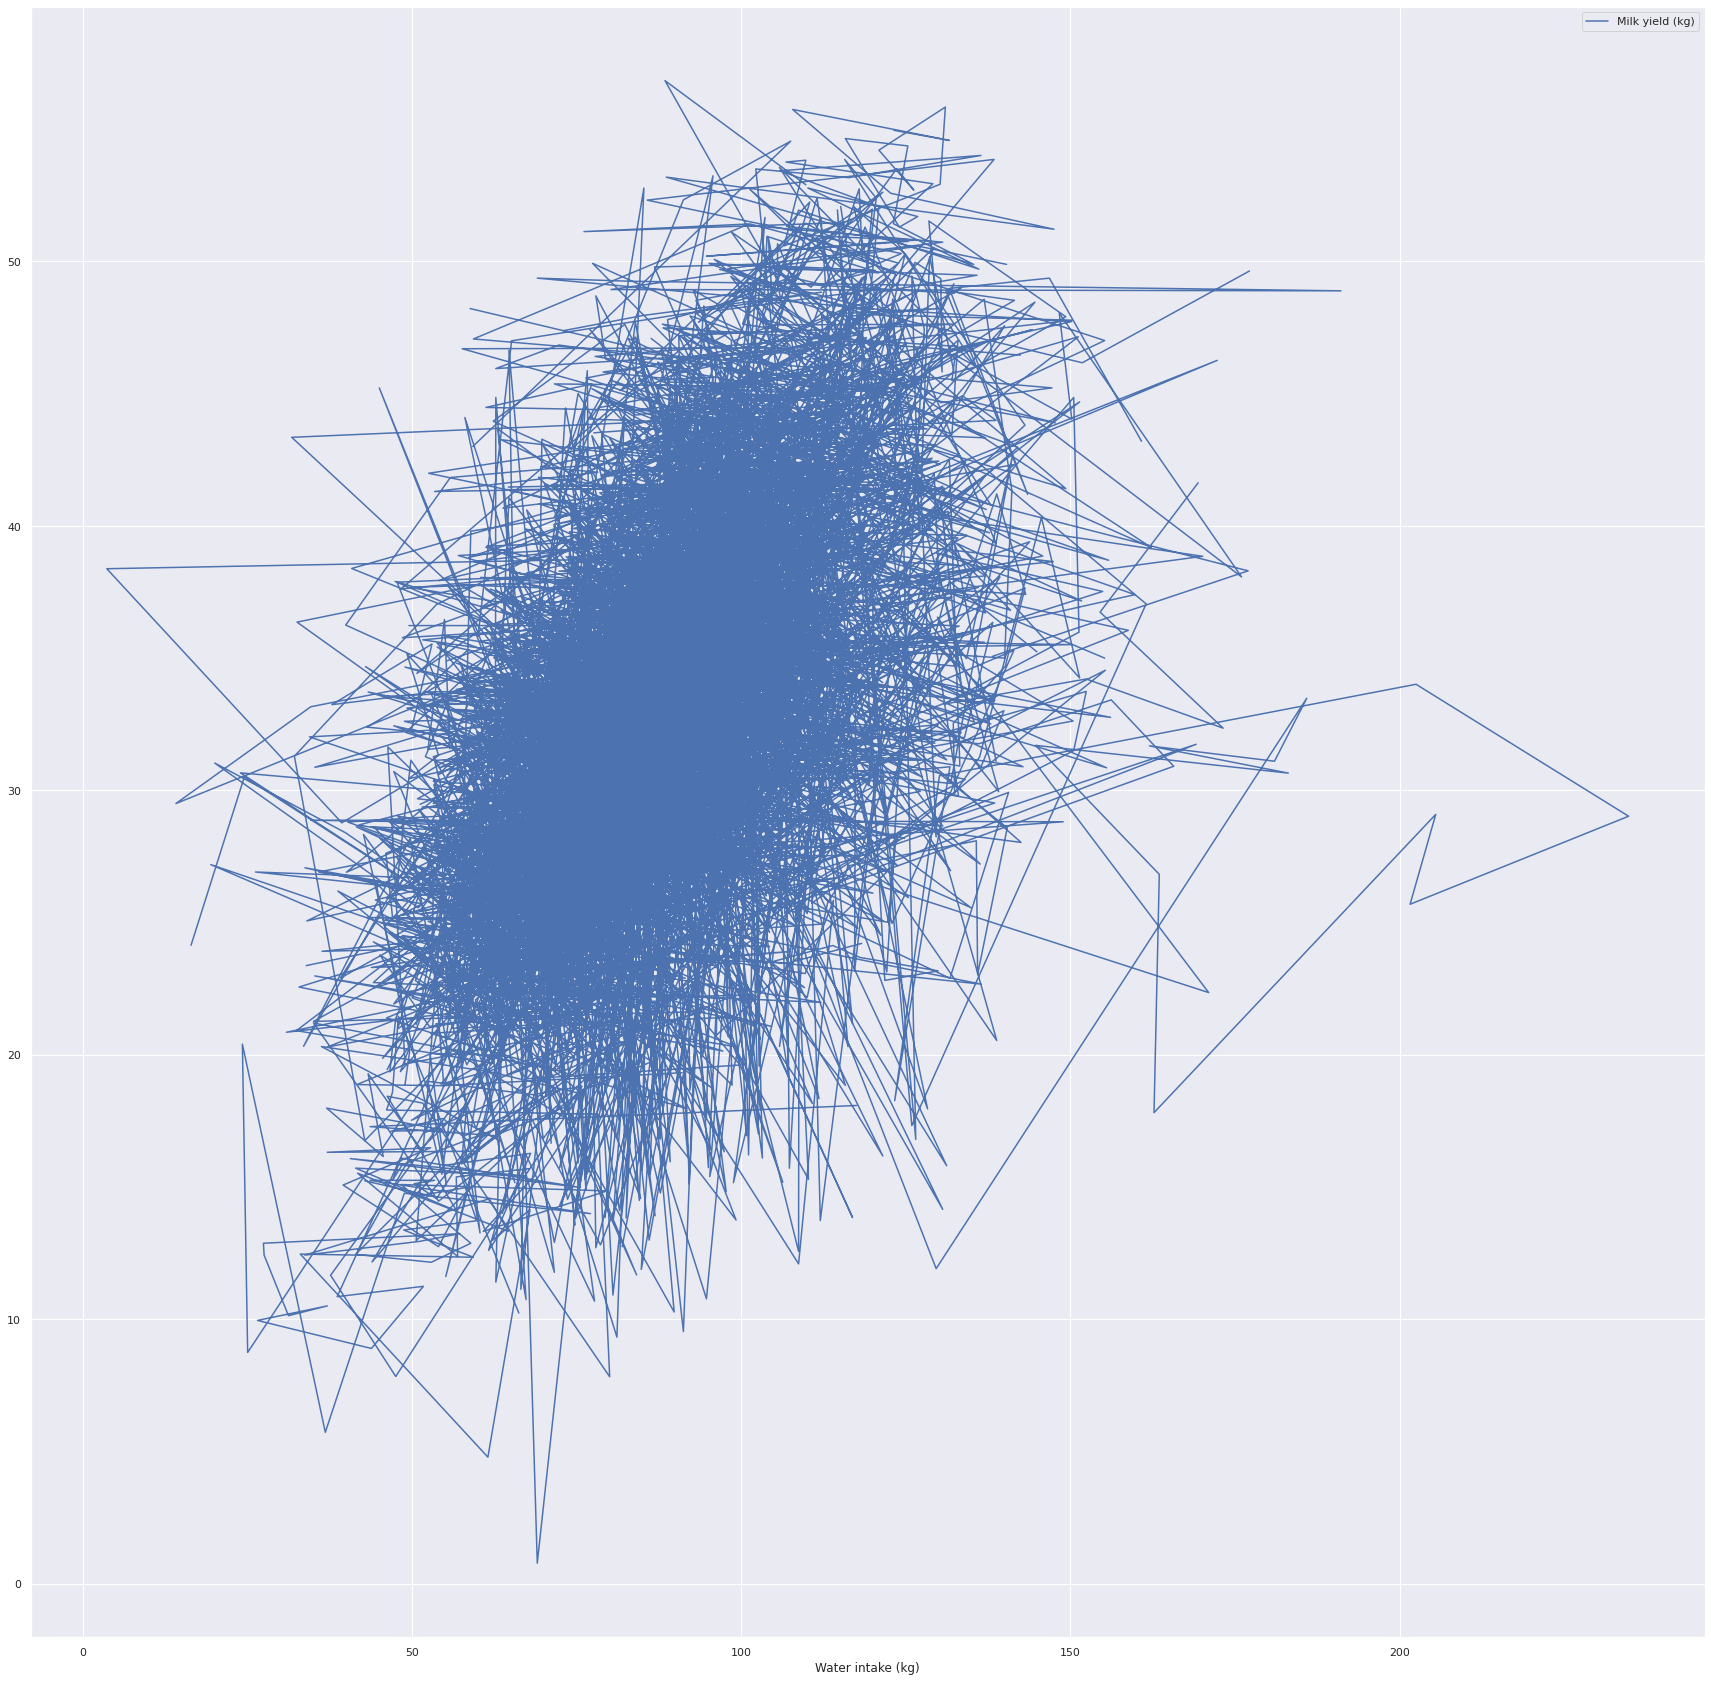

In [177]:
# Pandas Visualization
#print(milk_pd.head())
#print(milk_pd.columns)

milk_pd.plot( x='Water intake (kg)',y='Milk yield (kg)')

#print(milk_pd['plusI (/kg dm)'])

In [178]:
!ls '../bin'


bash	       hostname       su
bunzip2        journalctl     sync
bzcat	       kill	      systemctl
bzcmp	       kmod	      systemd
bzdiff	       less	      systemd-ask-password
bzegrep        lessecho       systemd-escape
bzexe	       lessfile       systemd-hwdb
bzfgrep        lesskey	      systemd-inhibit
bzgrep	       lesspipe       systemd-machine-id-setup
bzip2	       ln	      systemd-notify
bzip2recover   login	      systemd-sysusers
bzless	       loginctl       systemd-tmpfiles
bzmore	       ls	      systemd-tty-ask-password-agent
cat	       lsblk	      tar
chgrp	       lsmod	      tempfile
chmod	       mkdir	      touch
chown	       mknod	      true
cp	       mktemp	      udevadm
dash	       more	      ulockmgr_server
date	       mount	      umount
dd	       mountpoint     uname
df	       mv	      uncompress
dir	       networkctl     vdir
dmesg	       nisdomainname  wdctl
dnsdomainname  pidof	      which
domainname     ps	      ypdomainname
echo	       pwd	      zcat
egrep	     

In [179]:
from pyspark.ml.regression import LinearRegression

(training, valData, testData) = milk_rdd.randomSplit([0.6, 0.2, 0.2])


lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

IllegalArgumentException: ignored

In [ ]:
milk_rdd.printSchema()
milk_rdd.describe().show()

### Visualization of Data

In [ ]:
# Plotting to check linear regression
milk_rdd2 = milk_rdd.withColumn('res', milk_rdd['Milk yield (kg)']*milk_rdd['Fat%'])

sns.scatterplot(x='res', y='Crude fiber (g/day)', data=milk_rdd2.toPandas())